In [1]:
import uproot
import numpy as np
import awkward as ak

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib import rcParams
from matplotlib import colors
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import                                                                                                                  
import mplhep as hep
plt.style.use(hep.style.ROOT)
import os,sys

In [2]:
def getData(fname="", procName="Truth"):
    dq_dict = uproot.open(fname)["Truth"]
    dq_events = ak.zip({"Hits":ak.zip({
                                      "detID":   dq_dict["hit_detID"].array(),
                                      "edep":    dq_dict["hit_edep"].array(),
                                      "elmID":   dq_dict["hit_elmID"].array(),
                                      "truthx":  dq_dict["hit_truthx"].array(),
                                      "truthy":  dq_dict["hit_truthy"].array(),
                                      "truthz":  dq_dict["hit_truthz"].array(),
                                      }),
                        "Electrons":ak.zip({
                                            "ge": dq_dict["ge"].array(),
                                            "gvx": dq_dict["gvx"].array(),
                                            "gvy": dq_dict["gvy"].array(),
                                            "gvz": dq_dict["gvz"].array(),
                                            "gpt": dq_dict["gpt"].array(),

                                        }),
                        "Showers":ak.zip({
                                        "nshowers": dq_dict["n_showers"].array(),
                                        "sedep_ecal": dq_dict["sedep_ecal"].array(),
                                        "sx": dq_dict["sx_ecal"].array(),
                                        "sy": dq_dict["sy_ecal"].array(),
                                        "sz": dq_dict["sz_ecal"].array(),
                                        }),
                        "st1_hits":ak.zip({
                                        "gx": dq_dict["gx_st1"].array(),
                                        "gy": dq_dict["gy_st1"].array(),
                                        "gz": dq_dict["gz_st1"].array(),
                                        }),
                        "st2_hits":ak.zip({
                                        "gx": dq_dict["gx_st2"].array(),
                                        "gy": dq_dict["gy_st2"].array(),
                                        "gz": dq_dict["gz_st2"].array(),
                                        }),
                        "h1_hits":ak.zip({
                                        "gx": dq_dict["gx_h1"].array(),
                                        "gy": dq_dict["gy_h1"].array(),
                                        "gz": dq_dict["gz_h1"].array(),
                                        }),
                        "h2_hits":ak.zip({
                                        "gx": dq_dict["gx_h2"].array(),
                                        "gy": dq_dict["gy_h2"].array(),
                                        "gz": dq_dict["gz_h2"].array(),
                                        }),
                        "h4_hits":ak.zip({
                                        "gx": dq_dict["gx_h4"].array(),
                                        "gy": dq_dict["gy_h4"].array(),
                                        "gz": dq_dict["gz_h4"].array(),
                                        }),
                        "emcal_hits":ak.zip({
                                        "gx": dq_dict["gx_ecal"].array(),
                                        "gy": dq_dict["gy_ecal"].array(),
                                        "gz": dq_dict["gz_ecal"].array(),
                                        "nhits": dq_dict["nhits_ecal"].array(),
                                        }),
                       }, depth_limit=1)
    return dq_events

In [3]:
def emcal_aselection(arr):
    mask = (arr.detID == 100)
    return mask

def h1bt_selection(arr):
    mask = (arr.detID >= 31) & (arr.detID <= 32)
    return mask

def h1lr_selection(arr):
    mask = (arr.detID >= 33) & (arr.detID <= 34)
    return mask

def h2lr_selection(arr):
    mask = (arr.detID >= 35) & (arr.detID <= 36)
    return mask

def h2bt_selection(arr):
    mask = (arr.detID >= 37) & (arr.detID <= 38)
    return mask

def st3_selection(arr):
    mask = (arr.detID >= 19) & (arr.detID <= 30)
    return mask

def h41lr_selection(arr):
    mask = (arr.detID >= 41) & (arr.detID <= 42)
    return mask

def h42lr_selection(arr):
    mask = (arr.detID >= 43) & (arr.detID <= 44)
    return mask

In [18]:
def studyAcc(ifile,title,acceptances,mass):
    dq_events = getData(ifile,"Truth")
    # choosing the nevts for denominator (because all files have 10000 evts)
    den = len(dq_events)
    
    # choosing 500 evts for denominator
    den500 = False
    if den500:
        dq_events = dq_events[:500]
        den = 500
        
    dq_hits = dq_events["Hits"]
    dq_showers = dq_events["Showers"]
    dq_electrons = dq_events["Electrons"]
    dq_emcalhits = dq_events["emcal_hits"]

    h4_hits = dq_hits[h41lr_selection(dq_hits)]
    
    dq_sh_z = ak.fill_none(ak.pad_none(dq_showers.sz, 2, axis=1),0)
    dq_sh_e = ak.fill_none(ak.pad_none(dq_showers.sedep_ecal, 2, axis=1),-1)
    dq_e_ge = ak.fill_none(ak.pad_none(dq_electrons.ge, 2, axis=1),-1)
    
    shower_zero_mask = ak.any(dq_sh_e==0,axis=1)
    shower_zero_index = np.where(shower_zero_mask)
   
    h4y_mask = (h4_hits.truthy <= -100) & (h4_hits.truthz >= 100)
    h4y_index = np.where(ak.any(h4y_mask,axis=1))

    sh_h4_mask = shower_zero_mask & h4y_mask
    sh_h4_index = np.where(ak.any(sh_h4_mask,axis=1))
    
    eshower_mask = ak.all(dq_sh_e > 0.1*dq_e_ge,axis=1)
    eshower_index = np.where(eshower_mask)
    
    masks = {
        'shower_zero':shower_zero_index,
        'h4y_hits':h4y_index,
        'h4y_and_showerzero': sh_h4_index,
        'eshower':eshower_index
    }
    
    dq_evts = dq_events[ak.all(dq_e_ge>-1,axis=1)]

    print(mass,len(dq_evts),len(dq_events),den)
    for maskstr,m in masks.items():
        if maskstr in acceptances:
            acceptances[maskstr].append(len(m[0])/den)
        else:
            acceptances[maskstr] = [len(m[0])/den]
        #print(maskstr+':', len(m[0])/den)
    return acceptances

In [8]:
studyAcc('data/simana_electrons_Mar22/Brem_0.470915_z500_600_eps_-6.root',r'Brem m=0.47 GeV $v_z$:5-6 m',{},0.01)

0.01 10000 10000


{'shower_zero': [0.1824],
 'h4y_hits': [0.0],
 'h4y_and_showerzero': [0.0],
 'eshower': [0.7492]}

In [19]:
masses = {}
masses['Brem'] = ["0.011603","0.015117","0.025659","0.033428","0.043551",
                  "0.056739","0.073920",
                  "0.096304","0.125467","0.163460","0.212958","0.361459","0.470915","0.613515","0.799296",
                  "1.356670",
                  "1.767490","2.302710"
                 ]
masses['Eta'] = ["0.010502","0.012922","0.015900","0.019564","0.024072","0.029619","0.036445","0.044843","0.055176",
                 "0.067891","0.083535","0.102784","0.126469","0.155612","0.191470","0.235592","0.289880",
                 "0.540000"]
acceptances = {}
for proc in ["Brem","Eta"]:
    acceptances[proc] = {}
    print(proc)
    for mass in masses[proc]:
        ifile = "data/simana_electrons_Mar22/%s_%s_z500_600_eps_-6.root"%(proc,mass)
        studyAcc(ifile,'',acceptances[proc],mass)

Brem
0.011603 10000 10000 10000
0.015117 10000 10000 10000
0.025659 10000 10000 10000
0.033428 10000 10000 10000
0.043551 10000 10000 10000
0.056739 10000 10000 10000
0.073920 10000 10000 10000
0.096304 10000 10000 10000
0.125467 10000 10000 10000
0.163460 10000 10000 10000
0.212958 10000 10000 10000
0.361459 10000 10000 10000
0.470915 10000 10000 10000
0.613515 10000 10000 10000
0.799296 10000 10000 10000
1.356670 10000 10000 10000
1.767490 10000 10000 10000
2.302710 10000 10000 10000
Eta
0.010502 10000 10000 10000
0.012922 10000 10000 10000
0.015900 10000 10000 10000
0.019564 10000 10000 10000
0.024072 10000 10000 10000
0.029619 10000 10000 10000
0.036445 10000 10000 10000
0.044843 10000 10000 10000
0.055176 10000 10000 10000
0.067891 10000 10000 10000
0.083535 10000 10000 10000
0.102784 10000 10000 10000
0.126469 10000 10000 10000
0.155612 10000 10000 10000
0.191470 10000 10000 10000
0.235592 10000 10000 10000
0.289880 10000 10000 10000
0.540000 10000 10000 10000


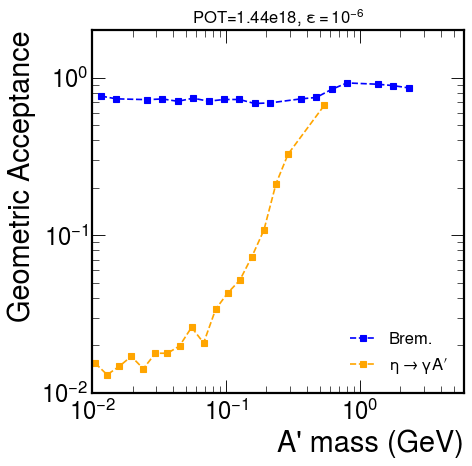

In [20]:
def plotAcceptance(masses,acceptances):
    fig, ax = plt.subplots(1,1,figsize=(6,6),dpi=80)
    labels = {'Brem': 'Brem.',
              'Eta': r'$\eta \rightarrow \gamma A\prime$',
             }
    colors = {'Brem': ['blue'],
              'Eta': ['orange'],
              }
    for proc,acc in acceptances.items():
        masslist = [float(i) for i in masses[proc]]
        plt.plot(masslist,acc['eshower'], color=colors[proc][0], label=labels[proc], marker='s', linestyle='dashed')
        #r'$E_{dep}^{EMCAL}>0.1 E_{e^-}$'
        #plt.plot(masses,acc['shower_zero'],color='blue', label=r'Shower edep==0') #(same as w. ecal hits)')
        #plt.plot(masses,acc['h4y_hits'],color='green', label=r'St4 hits  (out of acceptance)')
    ax.set_xlabel("A' mass (GeV)")
    ax.set_ylabel(r"Geometric Acceptance")
    ax.set_xlim(0.01,6) 
    ax.set_ylim(0.01,2)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.legend(prop={'size': 15})
    ax.set_title('POT=1.44e18, $\epsilon=10^{-6}$', fontsize=15)
    plt.show()
    #plt.savefig('acceptance_%s%s.png'%(mech,tag))
    
plotAcceptance(masses,acceptances)